In [33]:
!pip install pandas-ta
!pip install alpaca-trade-api
!pip install --upgrade yfinance

  Using cached websockets-10.4-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached websockets-10.4-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (107 kB)
  Attempting uninstall: websockets
    Found existing installation: websockets 15.0.1
    Uninstalling websockets-15.0.1:
      Successfully uninstalled websockets-15.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yfinance 0.2.64 requires websockets>=13.0, but you have websockets 10.4 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-genai 1.9.0 requires websockets<15.1.0,>=13.0.0, but you have websockets 10.4 which is incompatible.
  Using cached websockets-15.0.1-cp311-cp311-man

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pickle
import json
import os
from typing import Dict, List, Tuple, Optional, Any
import logging
from dataclasses import dataclass

# Data collection
import yfinance as yf
import pandas_ta as ta

# Machine Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR

# Gradient Boosting
import xgboost as xgb
import lightgbm as lgb

# AutoML
try:
    from autogluon.tabular import TabularPredictor
    AUTOGLUON_AVAILABLE = True
except ImportError:
    AUTOGLUON_AVAILABLE = False
    print("AutoGluon not available. Install with: pip install autogluon")

# TabPFN (if available)
try:
    from tabpfn import TabPFNRegressor
    TABPFN_AVAILABLE = True
except ImportError:
    TABPFN_AVAILABLE = False
    print("TabPFN not available. Install with: pip install tabpfn")

# Trading
import alpaca_trade_api as tradeapi

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

AutoGluon not available. Install with: pip install autogluon
TabPFN not available. Install with: pip install tabpfn


In [ ]:
@dataclass
class Config:
    """Configuration class for the trading system"""
    
    # Data parameters
    LOOKBACK_DAYS: int = 252 * 2  # 2 years of data
    PREDICTION_HORIZON: int = 5   # 5 days ahead prediction
    FEATURE_WINDOW: int = 20      # Technical indicator window
    
    # Model parameters
    TRAIN_TEST_SPLIT: float = 0.8
    VALIDATION_SPLIT: float = 0.2
    CROSS_VAL_FOLDS: int = 5
    
    # Portfolio parameters
    PORTFOLIO_ALLOCATION: float = 0.9  # 90% of portfolio
    MAX_POSITION_SIZE: float = 0.1     # Max 10% per stock
    MIN_CONFIDENCE: float = 0.6        # Minimum prediction confidence
    
    # Risk parameters
    MAX_DRAWDOWN: float = 0.15         # 15% max drawdown
    VAR_CONFIDENCE: float = 0.95       # 95% VaR
    MONTE_CARLO_SIMS: int = 10000      # Monte Carlo simulations
    
    # GPU settings
    USE_GPU: bool = torch.cuda.is_available()
    DEVICE: str = "cuda" if torch.cuda.is_available() else "cpu"
    
    # File paths
    MODEL_SAVE_PATH: str = "./models/"
    DATA_SAVE_PATH: str = "./data/"
    RESULTS_SAVE_PATH: str = "./results/"

config = Config()

# Create directories if they don't exist
for path in [config.MODEL_SAVE_PATH, config.DATA_SAVE_PATH, config.RESULTS_SAVE_PATH]:
    os.makedirs(path, exist_ok=True)

print(f"Using device: {config.DEVICE}")
print(f"GPU Available: {config.USE_GPU}")

Using device: cuda
GPU Available: True


In [36]:
class DataCollector:
    """Handles data collection and feature engineering for stocks"""
    
    def __init__(self, tickers: List[str]):
        self.tickers = tickers
        self.data = {}
        self.features = {}
        
    def fetch_stock_data(self, ticker: str, period: str = "2y") -> pd.DataFrame:
        """Fetch stock data from Yahoo Finance"""
        try:
            stock = yf.Ticker(ticker)
            data = stock.history(period=period)
            
            if data.empty:
                print(f"No data found for {ticker}")
                return pd.DataFrame()
                
            # Clean data
            data = data.dropna()
            data.index = pd.to_datetime(data.index)
            
            return data
        except Exception as e:
            print(f"Error fetching data for {ticker}: {e}")
            return pd.DataFrame()
    
    def calculate_technical_indicators(self, df: pd.DataFrame) -> pd.DataFrame:
        """Calculate comprehensive technical indicators with better feature diversity"""
        if df.empty:
            return df
            
        # Normalize prices to create stock-specific features
        df['Price_norm'] = df['Close'] / df['Close'].iloc[0]  # Normalized to first price
        df['Volume_norm'] = df['Volume'] / df['Volume'].mean()  # Normalized volume
        
        # Price-based indicators with multiple timeframes
        for period in [5, 10, 20, 50]:
            df[f'SMA_{period}'] = ta.sma(df['Close'], length=period)
            df[f'EMA_{period}'] = ta.ema(df['Close'], length=period)
            df[f'Price_vs_SMA_{period}'] = (df['Close'] - df[f'SMA_{period}']) / df[f'SMA_{period}']
            df[f'SMA_slope_{period}'] = df[f'SMA_{period}'].pct_change(periods=5)
        
        # Advanced momentum indicators
        df['RSI'] = ta.rsi(df['Close'], length=14)
        df['RSI_14'] = ta.rsi(df['Close'], length=14)
        df['RSI_21'] = ta.rsi(df['Close'], length=21)
        df['RSI_divergence'] = df['RSI_14'] - df['RSI_21']
        
        # MACD with multiple timeframes
        macd_12_26 = ta.macd(df['Close'], fast=12, slow=26)
        macd_8_21 = ta.macd(df['Close'], fast=8, slow=21)
        df['MACD'] = macd_12_26['MACD_12_26_9']
        df['MACD_signal'] = macd_12_26['MACDs_12_26_9']
        df['MACD_hist'] = macd_12_26['MACDh_12_26_9']
        df['MACD_fast'] = macd_8_21['MACD_8_21_9']
        df['MACD_crossover'] = (df['MACD'] > df['MACD_signal']).astype(int)
        
        # Volatility indicators
        bb_20 = ta.bbands(df['Close'], length=20)
        bb_10 = ta.bbands(df['Close'], length=10)
        df['BB_upper_20'] = bb_20['BBU_20_2.0']
        df['BB_middle_20'] = bb_20['BBM_20_2.0']
        df['BB_lower_20'] = bb_20['BBL_20_2.0']
        df['BB_width_20'] = (df['BB_upper_20'] - df['BB_lower_20']) / df['BB_middle_20']
        df['BB_position_20'] = (df['Close'] - df['BB_lower_20']) / (df['BB_upper_20'] - df['BB_lower_20'])
        
        df['BB_upper_10'] = bb_10['BBU_10_2.0']
        df['BB_width_10'] = (bb_10['BBU_10_2.0'] - bb_10['BBL_10_2.0']) / bb_10['BBM_10_2.0']
        
        # Advanced volume indicators
        df['Volume_SMA_20'] = ta.sma(df['Volume'], length=20)
        df['Volume_SMA_5'] = ta.sma(df['Volume'], length=5)
        df['Volume_ratio_20'] = df['Volume'] / df['Volume_SMA_20']
        df['Volume_ratio_5'] = df['Volume'] / df['Volume_SMA_5']
        df['OBV'] = ta.obv(df['Close'], df['Volume'])
        df['OBV_slope'] = df['OBV'].pct_change(periods=5)
        
        # Price action and momentum features
        df['Price_change'] = df['Close'].pct_change()
        df['Price_change_abs'] = df['Price_change'].abs()
        df['High_Low_ratio'] = (df['High'] - df['Low']) / df['Close']
        df['Close_Open_ratio'] = (df['Close'] - df['Open']) / df['Open']
        df['High_Close_ratio'] = (df['High'] - df['Close']) / df['Close']
        df['Close_Low_ratio'] = (df['Close'] - df['Low']) / df['Close']
        
        # Volatility measures
        for window in [5, 10, 20]:
            df[f'Volatility_{window}'] = df['Price_change'].rolling(window=window).std()
        
        # Trend strength indicators
        df['ADX'] = ta.adx(df['High'], df['Low'], df['Close'])['ADX_14']
        df['CCI'] = ta.cci(df['High'], df['Low'], df['Close'], length=20)
        df['Williams_R'] = ta.willr(df['High'], df['Low'], df['Close'], length=14)
        
        # Price position indicators
        for window in [10, 20, 50]:
            df[f'Price_position_{window}'] = (df['Close'] - df['Close'].rolling(window=window).min()) / \
                                           (df['Close'].rolling(window=window).max() - df['Close'].rolling(window=window).min())
            df[f'Volume_position_{window}'] = (df['Volume'] - df['Volume'].rolling(window=window).min()) / \
                                            (df['Volume'].rolling(window=window).max() - df['Volume'].rolling(window=window).min())
        
        # Lag features with different periods
        for lag in [1, 2, 3, 5, 10]:
            df[f'Return_lag_{lag}'] = df['Price_change'].shift(lag)
            df[f'Volume_change_lag_{lag}'] = df['Volume'].pct_change().shift(lag)
            df[f'RSI_lag_{lag}'] = df['RSI'].shift(lag)
            df[f'BB_position_lag_{lag}'] = df['BB_position_20'].shift(lag)
        
        # Rolling statistics with multiple windows
        for window in [5, 10, 20]:
            df[f'Return_mean_{window}'] = df['Price_change'].rolling(window=window).mean()
            df[f'Return_std_{window}'] = df['Price_change'].rolling(window=window).std()
            df[f'Return_skew_{window}'] = df['Price_change'].rolling(window=window).skew()
            df[f'Return_kurt_{window}'] = df['Price_change'].rolling(window=window).kurt()
            df[f'Return_min_{window}'] = df['Price_change'].rolling(window=window).min()
            df[f'Return_max_{window}'] = df['Price_change'].rolling(window=window).max()
        
        # Cross-asset momentum (if multiple timeframes)
        df['Momentum_5'] = df['Close'] / df['Close'].shift(5) - 1
        df['Momentum_10'] = df['Close'] / df['Close'].shift(10) - 1
        df['Momentum_20'] = df['Close'] / df['Close'].shift(20) - 1
        
        # Rate of change indicators
        for period in [5, 10, 20]:
            df[f'ROC_{period}'] = ta.roc(df['Close'], length=period)
            df[f'RSI_ROC_{period}'] = ta.roc(df['RSI'], length=period)
        
        # Stochastic indicators
        stoch = ta.stoch(df['High'], df['Low'], df['Close'])
        df['Stoch_K'] = stoch['STOCHk_14_3_3']
        df['Stoch_D'] = stoch['STOCHd_14_3_3']
        df['Stoch_diff'] = df['Stoch_K'] - df['Stoch_D']
        
        return df
    
    def create_target_variable(self, df: pd.DataFrame, horizon: int = 5) -> pd.DataFrame:
        """Create target variable for prediction"""
        if df.empty:
            return df
            
        # Future return over horizon days
        df['target_return'] = df['Close'].shift(-horizon) / df['Close'] - 1
        
        # Future volatility
        df['target_volatility'] = df['Price_change'].shift(-horizon).rolling(window=horizon).std()
        
        # Future direction (classification target)
        df['target_direction'] = (df['target_return'] > 0).astype(int)
        
        return df
    
    def collect_all_data(self) -> Dict[str, pd.DataFrame]:
        """Collect and process data for all tickers"""
        print("Starting data collection...")
        
        for ticker in self.tickers:
            print(f"Processing {ticker}...")
            
            # Fetch raw data
            raw_data = self.fetch_stock_data(ticker)
            if raw_data.empty:
                continue
                
            # Calculate technical indicators
            processed_data = self.calculate_technical_indicators(raw_data)
            
            # Create target variables
            processed_data = self.create_target_variable(processed_data, config.PREDICTION_HORIZON)
            
            # Store data
            self.data[ticker] = processed_data
            
        print(f"Data collection completed for {len(self.data)} tickers")
        return self.data
    
    def prepare_features(self, ticker: str) -> Tuple[np.ndarray, np.ndarray]:
        """Prepare features and targets for ML models"""
        if ticker not in self.data:
            return np.array([]), np.array([])
            
        df = self.data[ticker].copy()
        
        # Select feature columns (exclude OHLCV and target columns)
        feature_cols = [col for col in df.columns if not col.startswith(('Open', 'High', 'Low', 'Close', 'Volume', 'target_'))]
        
        # Remove rows with NaN values
        df = df.dropna()
        
        if df.empty:
            return np.array([]), np.array([])
        
        X = df[feature_cols].values
        y = df['target_return'].values
        
        return X, y

In [37]:
class MLPRegressor(nn.Module):
    """Improved Multi-Layer Perceptron for stock prediction with better architecture"""
    
    def __init__(self, input_size: int, hidden_sizes: List[int] = [512, 256, 128, 64], 
                 dropout_rate: float = 0.2, use_batch_norm: bool = True):
        super(MLPRegressor, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Input layer with batch norm
        if use_batch_norm:
            layers.append(nn.BatchNorm1d(input_size))
        
        for i, hidden_size in enumerate(hidden_sizes):
            # Linear layer
            layers.append(nn.Linear(prev_size, hidden_size))
            
            # Batch normalization
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))
            
            # Activation - use different activations for variety
            if i % 2 == 0:
                layers.append(nn.ReLU())
            else:
                layers.append(nn.LeakyReLU(0.1))
            
            # Dropout with different rates
            dropout = dropout_rate * (1 + i * 0.1)  # Increasing dropout in deeper layers
            layers.append(nn.Dropout(min(dropout, 0.5)))
            
            prev_size = hidden_size
        
        # Output layer with no activation (regression)
        layers.append(nn.Linear(prev_size, 1))
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights properly
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        """Proper weight initialization"""
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm1d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)
        
    def forward(self, x):
        return self.network(x)

class MLPTrainer:
    """Improved trainer class for MLP models with better training strategies"""
    
    def __init__(self, input_size: int, device: str = config.DEVICE):
        self.device = device
        self.model = MLPRegressor(input_size).to(device)
        self.criterion = nn.MSELoss()
        
        # Use different optimizers and learning rates
        self.optimizer = optim.AdamW(self.model.parameters(), lr=0.001, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=20, T_mult=2, eta_min=1e-6
        )
        
        # Early stopping
        self.best_val_loss = float('inf')
        self.patience = 20
        self.patience_counter = 0
        
    def train(self, X_train: np.ndarray, y_train: np.ndarray, 
              X_val: np.ndarray, y_val: np.ndarray, 
              epochs: int = 200, batch_size: int = 128) -> Dict[str, List[float]]:
        """Train the MLP model with improved training loop"""
        
        # Robust scaling to prevent identical predictions
        scaler_X = RobustScaler()
        scaler_y = RobustScaler()
        
        X_train_scaled = scaler_X.fit_transform(X_train)
        X_val_scaled = scaler_X.transform(X_val)
        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()
        
        # Store scalers for later use
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled).to(self.device)
        y_train_tensor = torch.FloatTensor(y_train_scaled).reshape(-1, 1).to(self.device)
        X_val_tensor = torch.FloatTensor(X_val_scaled).to(self.device)
        y_val_tensor = torch.FloatTensor(y_val_scaled).reshape(-1, 1).to(self.device)
        
        # Create data loaders with shuffling
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        
        history = {'train_loss': [], 'val_loss': []}
        
        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            
            for batch_X, batch_y in train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                
                # Add L1 regularization
                l1_lambda = 1e-5
                l1_norm = sum(p.abs().sum() for p in self.model.parameters())
                loss = loss + l1_lambda * l1_norm
                
                loss.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                self.optimizer.step()
                train_loss += loss.item()
            
            # Validation phase
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(X_val_tensor)
                val_loss = self.criterion(val_outputs, y_val_tensor).item()
            
            # Update learning rate
            self.scheduler.step()
            
            # Record history
            avg_train_loss = train_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(val_loss)
            
            # Early stopping
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0
                # Save best model state
                self.best_model_state = self.model.state_dict().copy()
            else:
                self.patience_counter += 1
                
            if self.patience_counter >= self.patience:
                print(f"Early stopping at epoch {epoch}")
                break
            
            if epoch % 50 == 0:
                print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.6f}, Val Loss = {val_loss:.6f}, LR = {self.scheduler.get_last_lr()[0]:.6f}")
        
        # Load best model
        if hasattr(self, 'best_model_state'):
            self.model.load_state_dict(self.best_model_state)
        
        return history
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions with proper scaling"""
        self.model.eval()
        with torch.no_grad():
            # Scale input
            X_scaled = self.scaler_X.transform(X)
            X_tensor = torch.FloatTensor(X_scaled).to(self.device)
            
            # Get predictions
            predictions_scaled = self.model(X_tensor).cpu().numpy().flatten()
            
            # Inverse scale predictions
            predictions = self.scaler_y.inverse_transform(predictions_scaled.reshape(-1, 1)).flatten()
            
        return predictions

In [38]:
class GradientBoostingEnsemble:
    """Ensemble of gradient boosting models"""
    
    def __init__(self):
        self.models = {}
        self.scalers = {}
        
    def create_xgboost_model(self) -> xgb.XGBRegressor:
        """Create XGBoost model with GPU support if available"""
        params = {
            'n_estimators': 1000,
            'max_depth': 6,
            'learning_rate': 0.01,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'n_jobs': -1,
            'early_stopping_rounds': 50
        }
        
        if config.USE_GPU:
            params['tree_method'] = 'gpu_hist'
            params['gpu_id'] = 0
            
        return xgb.XGBRegressor(**params)
    
    def create_lightgbm_model(self) -> lgb.LGBMRegressor:
        """Create LightGBM model with GPU support if available"""
        params = {
            'n_estimators': 1000,
            'max_depth': 6,
            'learning_rate': 0.01,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42,
            'n_jobs': -1,
            'verbose': -1
        }
        
        if config.USE_GPU:
            params['device'] = 'gpu'
            
        return lgb.LGBMRegressor(**params)
    
    def create_base_models(self) -> Dict[str, Any]:
        """Create base models for boosting"""
        base_models = {
            'lasso': Lasso(alpha=0.01, random_state=42),
            'svr': SVR(kernel='rbf', C=1.0, gamma='scale'),
            'rf': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
        }
        return base_models
    
    def train_boosted_models(self, X_train: np.ndarray, y_train: np.ndarray,
                           X_val: np.ndarray, y_val: np.ndarray) -> Dict[str, Any]:
        """Train gradient boosting models over base models"""
        
        base_models = self.create_base_models()
        boosted_models = {}
        
        for name, base_model in base_models.items():
            print(f"Training boosted model over {name}...")
            
            # Train base model
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            base_model.fit(X_train_scaled, y_train)
            base_pred_train = base_model.predict(X_train_scaled)
            base_pred_val = base_model.predict(X_val_scaled)
            
            # Calculate residuals
            residuals_train = y_train - base_pred_train
            residuals_val = y_val - base_pred_val
            
            # Train XGBoost on residuals
            xgb_model = self.create_xgboost_model()
            xgb_model.fit(X_train, residuals_train, 
                         eval_set=[(X_val, residuals_val)], 
                         verbose=False)
            
            boosted_models[f'boosted_{name}'] = {
                'base_model': base_model,
                'boost_model': xgb_model,
                'scaler': scaler
            }
        
        return boosted_models
    
    def train_all_models(self, X_train: np.ndarray, y_train: np.ndarray,
                        X_val: np.ndarray, y_val: np.ndarray) -> Dict[str, Any]:
        """Train all gradient boosting models"""
        
        all_models = {}
        
        # Standard XGBoost
        print("Training XGBoost...")
        xgb_model = self.create_xgboost_model()
        xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
        all_models['xgboost'] = xgb_model
        
        # Standard LightGBM
        print("Training LightGBM...")
        lgb_model = self.create_lightgbm_model()
        lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
                     callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
        all_models['lightgbm'] = lgb_model
        
        # Boosted models
        boosted_models = self.train_boosted_models(X_train, y_train, X_val, y_val)
        all_models.update(boosted_models)
        
        return all_models

In [39]:
class AutoMLEnsemble:
    """AutoML and TabPFN model ensemble"""
    
    def __init__(self):
        self.models = {}
        
    def train_autogluon(self, X_train: np.ndarray, y_train: np.ndarray,
                       X_val: np.ndarray, y_val: np.ndarray) -> Optional[Any]:
        """Train AutoGluon model if available"""
        if not AUTOGLUON_AVAILABLE:
            print("AutoGluon not available")
            return None
            
        try:
            # Prepare data for AutoGluon
            train_df = pd.DataFrame(X_train)
            train_df['target'] = y_train
            
            val_df = pd.DataFrame(X_val)
            val_df['target'] = y_val
            
            # Train AutoGluon
            predictor = TabularPredictor(
                label='target',
                problem_type='regression',
                eval_metric='mean_squared_error',
                path=os.path.join(config.MODEL_SAVE_PATH, 'autogluon_models')
            )
            
            predictor.fit(
                train_data=train_df,
                tuning_data=val_df,
                time_limit=600,  # 10 minutes
                presets='best_quality'
            )
            
            return predictor
            
        except Exception as e:
            print(f"Error training AutoGluon: {e}")
            return None
    
    def train_tabpfn(self, X_train: np.ndarray, y_train: np.ndarray) -> Optional[Any]:
        """Train TabPFN model if available"""
        if not TABPFN_AVAILABLE:
            print("TabPFN not available")
            return None
            
        try:
            # TabPFN has limitations on dataset size
            if X_train.shape[0] > 1000 or X_train.shape[1] > 100:
                # Sample data if too large
                indices = np.random.choice(X_train.shape[0], size=min(1000, X_train.shape[0]), replace=False)
                X_train_sample = X_train[indices]
                y_train_sample = y_train[indices]
                
                # Select top features if too many
                if X_train.shape[1] > 100:
                    from sklearn.feature_selection import SelectKBest, f_regression
                    selector = SelectKBest(f_regression, k=100)
                    X_train_sample = selector.fit_transform(X_train_sample, y_train_sample)
            else:
                X_train_sample = X_train
                y_train_sample = y_train
            
            model = TabPFNRegressor(device=config.DEVICE)
            model.fit(X_train_sample, y_train_sample)
            
            return model
            
        except Exception as e:
            print(f"Error training TabPFN: {e}")
            return None

In [40]:
class EnsembleStacker:
    """Multi-level ensemble stacking system"""
    
    def __init__(self):
        self.level1_models = {}
        self.level2_models = {}
        self.level3_model = None
        self.scalers = {}
        
    def train_level1_models(self, X_train: np.ndarray, y_train: np.ndarray,
                           X_val: np.ndarray, y_val: np.ndarray) -> Dict[str, Any]:
        """Train Level 1 base models"""
        
        level1_models = {}
        
        # Neural Network MLP
        print("Training Level 1: Neural Network MLP...")
        mlp_trainer = MLPTrainer(X_train.shape[1])
        mlp_trainer.train(X_train, y_train, X_val, y_val, epochs=100)
        level1_models['nn_mlp'] = mlp_trainer
        
        # Gradient Boosting Models
        print("Training Level 1: Gradient Boosting Models...")
        gb_ensemble = GradientBoostingEnsemble()
        gb_models = gb_ensemble.train_all_models(X_train, y_train, X_val, y_val)
        level1_models.update(gb_models)
        
        # AutoML Models
        print("Training Level 1: AutoML Models...")
        automl_ensemble = AutoMLEnsemble()
        
        autogluon_model = automl_ensemble.train_autogluon(X_train, y_train, X_val, y_val)
        if autogluon_model:
            level1_models['autogluon'] = autogluon_model
            
        tabpfn_model = automl_ensemble.train_tabpfn(X_train, y_train)
        if tabpfn_model:
            level1_models['tabpfn'] = tabpfn_model
        
        return level1_models
    
    def generate_level1_predictions(self, models: Dict[str, Any], X: np.ndarray) -> np.ndarray:
        """Generate predictions from Level 1 models"""
        
        predictions = []
        model_names = []
        
        for name, model in models.items():
            try:
                if name == 'nn_mlp':
                    pred = model.predict(X)
                elif name == 'autogluon':
                    pred_df = pd.DataFrame(X)
                    pred = model.predict(pred_df).values
                elif name == 'tabpfn':
                    pred = model.predict(X)
                elif name.startswith('boosted_'):
                    # Handle boosted models
                    base_model = model['base_model']
                    boost_model = model['boost_model']
                    scaler = model['scaler']
                    
                    X_scaled = scaler.transform(X)
                    base_pred = base_model.predict(X_scaled)
                    boost_pred = boost_model.predict(X)
                    pred = base_pred + boost_pred
                else:
                    # Standard sklearn-like models
                    pred = model.predict(X)
                
                predictions.append(pred.reshape(-1, 1))
                model_names.append(name)
                
            except Exception as e:
                print(f"Error generating predictions for {name}: {e}")
                continue
        
        if predictions:
            return np.hstack(predictions), model_names
        else:
            return np.array([]), []
    
    def train_level2_models(self, level1_predictions: np.ndarray, y_train: np.ndarray,
                           level1_val_predictions: np.ndarray, y_val: np.ndarray) -> Dict[str, Any]:
        """Train Level 2 meta-models"""
        
        level2_models = {}
        
        # XGBoost Level 2
        print("Training Level 2: XGBoost...")
        xgb_l2 = xgb.XGBRegressor(
            n_estimators=500,
            max_depth=4,
            learning_rate=0.05,
            random_state=42
        )
        if config.USE_GPU:
            xgb_l2.set_params(tree_method='gpu_hist', gpu_id=0)
        
        xgb_l2.fit(level1_predictions, y_train,
                   eval_set=[(level1_val_predictions, y_val)],
                   verbose=False)
        level2_models['xgboost_l2'] = xgb_l2
        
        # Neural Network Level 2
        print("Training Level 2: Neural Network...")
        nn_l2_trainer = MLPTrainer(level1_predictions.shape[1])
        nn_l2_trainer.train(level1_predictions, y_train, 
                           level1_val_predictions, y_val, epochs=50)
        level2_models['nn_mlp_l2'] = nn_l2_trainer
        
        return level2_models
    
    def train_level3_model(self, level2_predictions: np.ndarray, y_train: np.ndarray) -> Any:
        """Train Level 3 final ensemble model (Weighted Average)"""
        
        print("Training Level 3: Weighted Average...")
        
        # Use Ridge regression to learn optimal weights
        ridge_weights = Ridge(alpha=1.0, random_state=42)
        ridge_weights.fit(level2_predictions, y_train)
        
        return ridge_weights
    
    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            X_val: np.ndarray, y_val: np.ndarray) -> 'EnsembleStacker':
        """Fit the complete ensemble stacking system"""
        
        print("Starting ensemble stacking training...")
        
        # Level 1: Train base models
        self.level1_models = self.train_level1_models(X_train, y_train, X_val, y_val)
        
        # Generate Level 1 predictions
        level1_train_preds, model_names = self.generate_level1_predictions(self.level1_models, X_train)
        level1_val_preds, _ = self.generate_level1_predictions(self.level1_models, X_val)
        
        if level1_train_preds.size == 0:
            raise ValueError("No valid Level 1 predictions generated")
        
        # Level 2: Train meta-models
        self.level2_models = self.train_level2_models(level1_train_preds, y_train,
                                                     level1_val_preds, y_val)
        
        # Generate Level 2 predictions
        level2_train_preds, _ = self.generate_level1_predictions(self.level2_models, level1_train_preds)
        
        # Level 3: Train final ensemble
        if level2_train_preds.size > 0:
            self.level3_model = self.train_level3_model(level2_train_preds, y_train)
        
        print("Ensemble stacking training completed!")
        return self
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        """Make predictions using the complete ensemble"""
        
        # Level 1 predictions
        level1_preds, _ = self.generate_level1_predictions(self.level1_models, X)
        
        if level1_preds.size == 0:
            raise ValueError("No valid Level 1 predictions")
        
        # Level 2 predictions
        level2_preds, _ = self.generate_level1_predictions(self.level2_models, level1_preds)
        
        # Level 3 final prediction
        if self.level3_model and level2_preds.size > 0:
            final_preds = self.level3_model.predict(level2_preds)
        else:
            # Fallback to simple average of Level 1 predictions
            final_preds = np.mean(level1_preds, axis=1)
        
        return final_preds
    
    def get_prediction_confidence(self, X: np.ndarray) -> np.ndarray:
        """Calculate prediction confidence based on model agreement"""
        
        level1_preds, _ = self.generate_level1_predictions(self.level1_models, X)
        
        if level1_preds.size == 0:
            return np.zeros(X.shape[0])
        
        # Calculate confidence as inverse of prediction variance
        pred_std = np.std(level1_preds, axis=1)
        confidence = 1 / (1 + pred_std)  # Higher confidence for lower variance
        
        return confidence

In [41]:
class MonteCarloRiskAnalyzer:
    """Monte Carlo simulation for portfolio risk analysis"""
    
    def __init__(self, n_simulations: int = config.MONTE_CARLO_SIMS):
        self.n_simulations = n_simulations
        self.simulation_results = {}
        
    def geometric_brownian_motion(self, S0: float, mu: float, sigma: float, 
                                 T: float, N: int, n_paths: int = 1) -> np.ndarray:
        """Generate stock price paths using Geometric Brownian Motion"""
        
        dt = T / N
        
        # Generate random shocks
        Z = np.random.normal(0, 1, size=(n_paths, N))
        
        # Initialize price paths
        paths = np.zeros((n_paths, N + 1))
        paths[:, 0] = S0
        
        # Generate paths
        for t in range(1, N + 1):
            paths[:, t] = paths[:, t-1] * np.exp(
                (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z[:, t-1]
            )
        
        return paths
    
    def estimate_stock_parameters(self, prices: pd.Series) -> Tuple[float, float]:
        """Estimate drift and volatility from historical prices"""
        
        returns = prices.pct_change().dropna()
        
        # Annualized parameters
        mu = returns.mean() * 252  # Drift
        sigma = returns.std() * np.sqrt(252)  # Volatility
        
        return mu, sigma
    
    def simulate_portfolio_paths(self, tickers: List[str], weights: np.ndarray,
                                predictions: Dict[str, float], 
                                historical_data: Dict[str, pd.DataFrame],
                                time_horizon: int = 5) -> Dict[str, Any]:
        """Simulate portfolio paths using Monte Carlo"""
        
        print("Running Monte Carlo portfolio simulation...")
        
        portfolio_paths = np.zeros((self.n_simulations, time_horizon + 1))
        portfolio_paths[:, 0] = 1.0  # Normalized initial value
        
        individual_paths = {}
        
        for i, ticker in enumerate(tickers):
            if ticker not in historical_data:
                continue
                
            # Get current price and estimate parameters
            current_price = historical_data[ticker]['Close'].iloc[-1]
            mu, sigma = self.estimate_stock_parameters(historical_data[ticker]['Close'])
            
            # Adjust drift based on prediction
            if ticker in predictions:
                # Incorporate prediction into drift
                predicted_return = predictions[ticker]
                adjusted_mu = mu * 0.7 + predicted_return * 252 * 0.3  # Blend historical and predicted
            else:
                adjusted_mu = mu
            
            # Generate paths for this stock
            stock_paths = self.geometric_brownian_motion(
                S0=current_price,
                mu=adjusted_mu,
                sigma=sigma,
                T=time_horizon/252,  # Convert days to years
                N=time_horizon,
                n_paths=self.n_simulations
            )
            
            # Convert to returns and weight
            stock_returns = stock_paths[:, -1] / stock_paths[:, 0] - 1
            individual_paths[ticker] = stock_returns
            
            # Add to portfolio
            portfolio_paths[:, -1] += weights[i] * stock_returns
        
        # Calculate portfolio statistics
        final_returns = portfolio_paths[:, -1]
        
        results = {
            'final_returns': final_returns,
            'individual_paths': individual_paths,
            'mean_return': np.mean(final_returns),
            'std_return': np.std(final_returns),
            'var_95': np.percentile(final_returns, 5),  # 95% VaR
            'var_99': np.percentile(final_returns, 1),  # 99% VaR
            'prob_loss': np.mean(final_returns < 0),
            'max_loss': np.min(final_returns),
            'max_gain': np.max(final_returns)
        }
        
        return results
    
    def plot_simulation_results(self, results: Dict[str, Any], save_path: str = None):
        """Plot Monte Carlo simulation results"""
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # Histogram of final returns
        ax1.hist(results['final_returns'], bins=50, alpha=0.7, density=True)
        ax1.axvline(results['var_95'], color='red', linestyle='--', 
                   label=f"95% VaR: {results['var_95']:.3f}")
        ax1.axvline(0, color='orange', linestyle='-', alpha=0.7, label='Break-even')
        ax1.set_xlabel('Portfolio Return')
        ax1.set_ylabel('Density')
        ax1.set_title('Distribution of Portfolio Returns')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Risk metrics text
        risk_text = f"""
        Mean Return: {results['mean_return']:.3f}
        Std Return: {results['std_return']:.3f}
        95% VaR: {results['var_95']:.3f}
        99% VaR: {results['var_99']:.3f}
        Prob of Loss: {results['prob_loss']:.3f}
        Max Loss: {results['max_loss']:.3f}
        Max Gain: {results['max_gain']:.3f}
        """
        
        ax2.text(0.1, 0.5, risk_text, transform=ax2.transAxes, fontsize=12,
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='lightgray'))
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.axis('off')
        ax2.set_title('Risk Metrics')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
        
        return fig

In [42]:
class PortfolioOptimizer:
    """Improved portfolio optimization using predictions and risk constraints"""
    
    def __init__(self, max_allocation: float = config.PORTFOLIO_ALLOCATION,
                 max_position_size: float = config.MAX_POSITION_SIZE):
        self.max_allocation = max_allocation
        self.max_position_size = max_position_size
        
    def calculate_position_sizes(self, predictions: Dict[str, float],
                               confidences: Dict[str, float],
                               risk_metrics: Dict[str, Any] = None) -> Dict[str, Dict[str, float]]:
        """Calculate position sizes ensuring 90% portfolio allocation"""
        
        positions = {}
        
        # Filter predictions by minimum confidence (lower threshold for more positions)
        min_confidence = max(0.3, config.MIN_CONFIDENCE - 0.3)  # Lower minimum confidence
        filtered_predictions = {
            ticker: pred for ticker, pred in predictions.items()
            if confidences.get(ticker, 0) >= min_confidence
        }
        
        if not filtered_predictions:
            print(f"No predictions meet minimum confidence threshold of {min_confidence}")
            return positions
        
        print(f"Using {len(filtered_predictions)} stocks with confidence >= {min_confidence}")
        
        # Separate long and short positions
        long_positions = {k: v for k, v in filtered_predictions.items() if v > 0}
        short_positions = {k: abs(v) for k, v in filtered_predictions.items() if v < 0}
        
        print(f"Long positions: {len(long_positions)}, Short positions: {len(short_positions)}")
        
        # Calculate weights ensuring we use the full allocation
        def calculate_weights(pos_dict: Dict[str, float], target_allocation: float) -> Dict[str, float]:
            if not pos_dict:
                return {}
            
            weights = {}
            
            # Calculate raw scores
            for ticker, pred in pos_dict.items():
                confidence = confidences.get(ticker, 0.5)
                # Enhanced scoring: prediction magnitude * confidence^2 for better differentiation
                score = abs(pred) * (confidence ** 1.5)
                weights[ticker] = score
            
            # Normalize to target allocation
            total_score = sum(weights.values())
            if total_score > 0:
                for ticker in weights:
                    # Scale to target allocation
                    raw_weight = (weights[ticker] / total_score) * target_allocation
                    # Apply position size limits but ensure minimum allocation
                    min_weight = target_allocation / (len(pos_dict) * 10)  # Minimum 1/10th of equal weight
                    weights[ticker] = max(min_weight, min(raw_weight, self.max_position_size))
            
            # Rescale to exactly hit target allocation
            current_total = sum(weights.values())
            if current_total > 0:
                scale_factor = target_allocation / current_total
                for ticker in weights:
                    weights[ticker] *= scale_factor
            
            return weights
        
        # Allocate 45% to longs, 45% to shorts (90% total)
        long_allocation = self.max_allocation / 2
        short_allocation = self.max_allocation / 2
        
        # If we have more longs than shorts (or vice versa), adjust allocation
        if len(long_positions) == 0 and len(short_positions) > 0:
            short_allocation = self.max_allocation
        elif len(short_positions) == 0 and len(long_positions) > 0:
            long_allocation = self.max_allocation
        elif len(long_positions) > 0 and len(short_positions) > 0:
            # Adjust based on relative strength of predictions
            long_strength = sum(abs(v) * confidences.get(k, 0.5) for k, v in long_positions.items())
            short_strength = sum(abs(v) * confidences.get(k, 0.5) for k, v in short_positions.items())
            total_strength = long_strength + short_strength
            
            if total_strength > 0:
                long_allocation = self.max_allocation * (long_strength / total_strength)
                short_allocation = self.max_allocation * (short_strength / total_strength)
        
        # Calculate weights
        long_weights = calculate_weights(long_positions, long_allocation)
        short_weights = calculate_weights(short_positions, short_allocation)
        
        # Combine positions
        for ticker, weight in long_weights.items():
            positions[ticker] = {
                'side': 'buy',
                'weight': weight,
                'prediction': predictions[ticker],
                'confidence': confidences[ticker]
            }
        
        for ticker, weight in short_weights.items():
            positions[ticker] = {
                'side': 'sell',
                'weight': weight,
                'prediction': predictions[ticker],
                'confidence': confidences[ticker]
            }
        
        # Verify total allocation
        total_allocation = sum(pos['weight'] for pos in positions.values())
        print(f"Total portfolio allocation: {total_allocation:.4f} (target: {self.max_allocation})")
        
        # If we're still under-allocated, scale up proportionally
        if total_allocation < self.max_allocation * 0.8:  # If less than 80% of target
            scale_factor = self.max_allocation / max(total_allocation, 0.01)
            for ticker in positions:
                positions[ticker]['weight'] *= scale_factor
            
            total_allocation = sum(pos['weight'] for pos in positions.values())
            print(f"Scaled total portfolio allocation: {total_allocation:.4f}")
        
        return positions
    
    def optimize_portfolio_risk(self, positions: Dict[str, Dict[str, float]],
                               historical_data: Dict[str, pd.DataFrame]) -> Dict[str, Dict[str, float]]:
        """Optimize portfolio for risk-adjusted returns"""
        
        if not positions:
            return positions
        
        tickers = list(positions.keys())
        
        # Calculate correlation matrix
        returns_data = []
        for ticker in tickers:
            if ticker in historical_data:
                returns = historical_data[ticker]['Close'].pct_change().dropna()
                returns_data.append(returns)
        
        if len(returns_data) < 2:
            return positions  # Can't optimize with less than 2 assets
        
        # Align returns data
        returns_df = pd.concat(returns_data, axis=1, keys=tickers).dropna()
        correlation_matrix = returns_df.corr()
        
        # Simple risk adjustment: reduce weights for highly correlated positions
        adjusted_positions = positions.copy()
        
        for i, ticker1 in enumerate(tickers):
            for j, ticker2 in enumerate(tickers):
                if i < j and ticker1 in correlation_matrix.index and ticker2 in correlation_matrix.columns:
                    corr = abs(correlation_matrix.loc[ticker1, ticker2])
                    
                    if corr > 0.7:  # High correlation
                        # Reduce weights proportionally
                        reduction_factor = 1 - (corr - 0.7) * 0.5
                        adjusted_positions[ticker1]['weight'] *= reduction_factor
                        adjusted_positions[ticker2]['weight'] *= reduction_factor
        
        return adjusted_positions

In [44]:
class ModelManager:
    """Handles saving and loading of trained models"""
    
    def __init__(self, base_path: str = config.MODEL_SAVE_PATH):
        self.base_path = base_path
        os.makedirs(base_path, exist_ok=True)
    
    def save_ensemble_model(self, ensemble: EnsembleStacker, 
                           metadata: Dict[str, Any], 
                           model_name: str = "ensemble_model") -> str:
        """Save the complete ensemble model"""
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_dir = os.path.join(self.base_path, f"{model_name}_{timestamp}")
        os.makedirs(model_dir, exist_ok=True)
        
        # Save ensemble object
        ensemble_path = os.path.join(model_dir, "ensemble.pkl")
        with open(ensemble_path, 'wb') as f:
            pickle.dump(ensemble, f)
        
        # Save metadata
        metadata_path = os.path.join(model_dir, "metadata.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        
        # Save individual PyTorch models separately
        torch_models = {}
        for name, model in ensemble.level1_models.items():
            if isinstance(model, MLPTrainer):
                torch_path = os.path.join(model_dir, f"{name}_torch.pth")
                torch.save(model.model.state_dict(), torch_path)
                torch_models[name] = torch_path
        
        for name, model in ensemble.level2_models.items():
            if isinstance(model, MLPTrainer):
                torch_path = os.path.join(model_dir, f"{name}_torch.pth")
                torch.save(model.model.state_dict(), torch_path)
                torch_models[name] = torch_path
        
        # Save torch model paths
        if torch_models:
            torch_paths_file = os.path.join(model_dir, "torch_models.json")
            with open(torch_paths_file, 'w') as f:
                json.dump(torch_models, f, indent=2)
        
        print(f"Model saved to: {model_dir}")
        return model_dir
    
    def load_ensemble_model(self, model_path: str) -> Tuple[EnsembleStacker, Dict[str, Any]]:
        """Load a saved ensemble model"""
        
        # Load ensemble object
        ensemble_path = os.path.join(model_path, "ensemble.pkl")
        with open(ensemble_path, 'rb') as f:
            ensemble = pickle.load(f)
        
        # Load metadata
        metadata_path = os.path.join(model_path, "metadata.json")
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        # Load PyTorch models if they exist
        torch_paths_file = os.path.join(model_path, "torch_models.json")
        if os.path.exists(torch_paths_file):
            with open(torch_paths_file, 'r') as f:
                torch_models = json.load(f)
            
            # Reload PyTorch model states
            for name, torch_path in torch_models.items():
                if name in ensemble.level1_models and isinstance(ensemble.level1_models[name], MLPTrainer):
                    ensemble.level1_models[name].model.load_state_dict(torch.load(torch_path, map_location=config.DEVICE))
                elif name in ensemble.level2_models and isinstance(ensemble.level2_models[name], MLPTrainer):
                    ensemble.level2_models[name].model.load_state_dict(torch.load(torch_path, map_location=config.DEVICE))
        
        print(f"Model loaded from: {model_path}")
        return ensemble, metadata
    
    def list_saved_models(self) -> List[Dict[str, Any]]:
        """List all saved models with their metadata"""
        
        models = []
        
        for item in os.listdir(self.base_path):
            item_path = os.path.join(self.base_path, item)
            if os.path.isdir(item_path):
                metadata_path = os.path.join(item_path, "metadata.json")
                if os.path.exists(metadata_path):
                    try:
                        with open(metadata_path, 'r') as f:
                            metadata = json.load(f)
                        
                        models.append({
                            'name': item,
                            'path': item_path,
                            'metadata': metadata
                        })
                    except Exception as e:
                        print(f"Could not load metadata for {item}: {e}")
        
        return sorted(models, key=lambda x: x['name'], reverse=True)

In [ ]:
class StockPredictionTradingSystem:
    """Main system orchestrating the entire pipeline"""
    
    def __init__(self, tickers_file: str = "tickers.txt"):
        # Load tickers
        with open(tickers_file, 'r') as f:
            self.tickers = [line.strip() for line in f.readlines() if line.strip()]
        
        print(f"Loaded {len(self.tickers)} tickers")
        
        # Initialize components
        self.data_collector = DataCollector(self.tickers)
        self.ensemble = EnsembleStacker()
        self.risk_analyzer = MonteCarloRiskAnalyzer()
        self.portfolio_optimizer = PortfolioOptimizer()
        self.model_manager = ModelManager()
        
        # Data storage
        self.historical_data = {}
        self.predictions = {}
        self.confidences = {}
        self.portfolio_positions = {}
        
    def collect_and_prepare_data(self) -> bool:
        """Collect and prepare all data for training"""
        
        print("=== DATA COLLECTION PHASE ===")
        
        # Collect historical data
        self.historical_data = self.data_collector.collect_all_data()
        
        if not self.historical_data:
            print("No data collected. Exiting.")
            return False
        
        print(f"Successfully collected data for {len(self.historical_data)} stocks")
        
        # Save raw data
        data_file = os.path.join(config.DATA_SAVE_PATH, f"historical_data_{datetime.now().strftime('%Y%m%d')}.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(self.historical_data, f)
        
        return True
    
    def train_prediction_models(self) -> bool:
        """Train individual prediction models for each stock for better accuracy"""
        
        print("=== MODEL TRAINING PHASE ===")
        
        # Train individual models for each stock
        self.individual_models = {}
        self.individual_scalers = {}
        
        successful_models = 0
        
        for ticker in self.tickers:
            if ticker not in self.historical_data:
                continue
                
            print(f"Training model for {ticker}...")
            
            try:
                X, y = self.data_collector.prepare_features(ticker)
                
                if X.size == 0 or y.size == 0 or len(X) < 100:  # Need minimum data
                    print(f"Insufficient data for {ticker}")
                    continue
                
                # Remove any infinite or NaN values
                mask = np.isfinite(X).all(axis=1) & np.isfinite(y)
                X = X[mask]
                y = y[mask]
                
                if len(X) < 50:
                    continue
                
                # Split data
                split_idx = int(len(X) * 0.8)
                X_train, X_test = X[:split_idx], X[split_idx:]
                y_train, y_test = y[:split_idx], y[split_idx:]
                
                # Further split training for validation
                val_split_idx = int(len(X_train) * 0.8)
                X_train_sub, X_val = X_train[:val_split_idx], X_train[val_split_idx:]
                y_train_sub, y_val = y_train[:val_split_idx], y_train[val_split_idx:]
                
                # Create ensemble for this stock
                stock_ensemble = EnsembleStacker()
                
                # Train Level 1 models
                level1_models = {}
                
                # Neural Network
                mlp_trainer = MLPTrainer(X_train_sub.shape[1])
                mlp_trainer.train(X_train_sub, y_train_sub, X_val, y_val, epochs=150)
                level1_models['nn_mlp'] = mlp_trainer
                
                # XGBoost
                xgb_model = xgb.XGBRegressor(
                    n_estimators=500,
                    max_depth=6,
                    learning_rate=0.01,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42
                )
                if config.USE_GPU:
                    xgb_model.set_params(tree_method='gpu_hist', gpu_id=0)
                
                xgb_model.fit(X_train_sub, y_train_sub,
                             eval_set=[(X_val, y_val)],
                             early_stopping_rounds=50,
                             verbose=False)
                level1_models['xgboost'] = xgb_model
                
                # LightGBM
                lgb_model = lgb.LGBMRegressor(
                    n_estimators=500,
                    max_depth=6,
                    learning_rate=0.01,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    random_state=42,
                    verbose=-1
                )
                if config.USE_GPU:
                    lgb_model.set_params(device='gpu')
                
                lgb_model.fit(X_train_sub, y_train_sub,
                             eval_set=[(X_val, y_val)],
                             callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)])
                level1_models['lightgbm'] = lgb_model
                
                # Random Forest
                rf_model = RandomForestRegressor(
                    n_estimators=200,
                    max_depth=10,
                    random_state=42,
                    n_jobs=-1
                )
                rf_model.fit(X_train_sub, y_train_sub)
                level1_models['random_forest'] = rf_model
                
                # Store models
                stock_ensemble.level1_models = level1_models
                
                # Generate Level 1 predictions for Level 2 training
                level1_train_preds = []
                level1_val_preds = []
                
                for name, model in level1_models.items():
                    if name == 'nn_mlp':
                        train_pred = model.predict(X_train_sub)
                        val_pred = model.predict(X_val)
                    else:
                        train_pred = model.predict(X_train_sub)
                        val_pred = model.predict(X_val)
                    
                    level1_train_preds.append(train_pred.reshape(-1, 1))
                    level1_val_preds.append(val_pred.reshape(-1, 1))
                
                if level1_train_preds:
                    level1_train_combined = np.hstack(level1_train_preds)
                    level1_val_combined = np.hstack(level1_val_preds)
                    
                    # Level 2: Meta-model (simple Ridge regression)
                    meta_model = Ridge(alpha=1.0, random_state=42)
                    meta_model.fit(level1_train_combined, y_train_sub)
                    
                    stock_ensemble.level2_models = {'ridge_meta': meta_model}
                    stock_ensemble.level3_model = None  # Use Level 2 as final
                
                # Test the ensemble
                test_pred = self._predict_with_stock_ensemble(stock_ensemble, X_test)
                test_mse = mean_squared_error(y_test, test_pred)
                test_r2 = r2_score(y_test, test_pred)
                
                print(f"{ticker} - Test MSE: {test_mse:.6f}, R²: {test_r2:.6f}")
                
                # Store successful model
                self.individual_models[ticker] = stock_ensemble
                successful_models += 1
                
            except Exception as e:
                print(f"Failed to train model for {ticker}: {e}")
                continue
        
        print(f"Successfully trained models for {successful_models} stocks")
        return successful_models > 0
    
    def _predict_with_stock_ensemble(self, ensemble, X):
        """Helper method to predict with individual stock ensemble"""
        
        # Level 1 predictions
        level1_preds = []
        for name, model in ensemble.level1_models.items():
            if name == 'nn_mlp':
                pred = model.predict(X)
            else:
                pred = model.predict(X)
            level1_preds.append(pred.reshape(-1, 1))
        
        if not level1_preds:
            return np.zeros(X.shape[0])
        
        level1_combined = np.hstack(level1_preds)
        
        # Level 2 prediction
        if ensemble.level2_models and 'ridge_meta' in ensemble.level2_models:
            final_pred = ensemble.level2_models['ridge_meta'].predict(level1_combined)
        else:
            # Fallback to simple average
            final_pred = np.mean(level1_combined, axis=1)
        
        return final_pred
    
    def generate_predictions(self) -> bool:
        """Generate predictions using individual stock models"""
        
        print("=== PREDICTION GENERATION PHASE ===")
        
        if not hasattr(self, 'individual_models'):
            print("No individual models found. Run training first.")
            return False
        
        for ticker in self.individual_models.keys():
            try:
                X, y = self.data_collector.prepare_features(ticker)
                
                if X.size == 0:
                    continue
                
                # Use the last 10 data points for prediction (more stable)
                X_recent = X[-10:] if len(X) >= 10 else X[-1:]
                
                # Get ensemble prediction
                ensemble = self.individual_models[ticker]
                predictions_recent = self._predict_with_stock_ensemble(ensemble, X_recent)
                
                # Use the mean of recent predictions
                prediction = np.mean(predictions_recent)
                
                # Calculate confidence based on prediction consistency
                if len(predictions_recent) > 1:
                    pred_std = np.std(predictions_recent)
                    confidence = 1 / (1 + pred_std * 10)  # Higher confidence for lower variance
                else:
                    confidence = 0.5
                
                # Ensure reasonable bounds
                prediction = np.clip(prediction, -0.5, 0.5)  # Limit to ±50% returns
                confidence = np.clip(confidence, 0.1, 0.99)
                
                self.predictions[ticker] = prediction
                self.confidences[ticker] = confidence
                
                print(f"{ticker}: Prediction = {prediction:.4f}, Confidence = {confidence:.4f}")
                
            except Exception as e:
                print(f"Could not generate prediction for {ticker}: {e}")
                continue
        
        print(f"Generated predictions for {len(self.predictions)} stocks")
        
        # Log prediction statistics
        if self.predictions:
            pred_values = list(self.predictions.values())
            conf_values = list(self.confidences.values())
            
            print(f"Prediction stats - Mean: {np.mean(pred_values):.4f}, "
                       f"Std: {np.std(pred_values):.4f}, "
                       f"Min: {np.min(pred_values):.4f}, "
                       f"Max: {np.max(pred_values):.4f}")
            print(f"Confidence stats - Mean: {np.mean(conf_values):.4f}, "
                       f"Min: {np.min(conf_values):.4f}, "
                       f"Max: {np.max(conf_values):.4f}")
        
        return len(self.predictions) > 0
    
    def analyze_portfolio_risk(self) -> Dict[str, Any]:
        """Analyze portfolio risk using Monte Carlo simulation"""
        
        print("=== RISK ANALYSIS PHASE ===")
        
        if not self.predictions:
            print("No predictions available for risk analysis")
            return {}
        
        # Get tickers with predictions
        predicted_tickers = list(self.predictions.keys())
        
        # Create equal weights for simulation (will be optimized later)
        weights = np.ones(len(predicted_tickers)) / len(predicted_tickers)
        
        # Run Monte Carlo simulation
        risk_results = self.risk_analyzer.simulate_portfolio_paths(
            tickers=predicted_tickers,
            weights=weights,
            predictions=self.predictions,
            historical_data=self.historical_data,
            time_horizon=config.PREDICTION_HORIZON
        )
        
        # Plot results
        plot_path = os.path.join(config.RESULTS_SAVE_PATH, f"risk_analysis_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        self.risk_analyzer.plot_simulation_results(risk_results, plot_path)
        
        print("Risk Analysis Results:")
        print(f"  Expected Return: {risk_results['mean_return']:.4f}")
        print(f"  Volatility: {risk_results['std_return']:.4f}")
        print(f"  95% VaR: {risk_results['var_95']:.4f}")
        print(f"  Probability of Loss: {risk_results['prob_loss']:.4f}")
        
        return risk_results
    
    def optimize_portfolio(self, risk_results: Dict[str, Any] = None) -> Dict[str, Dict[str, float]]:
        """Optimize portfolio allocation"""
        
        print("=== PORTFOLIO OPTIMIZATION PHASE ===")
        
        # Calculate position sizes
        positions = self.portfolio_optimizer.calculate_position_sizes(
            self.predictions, self.confidences, risk_results
        )
        
        # Risk-adjust positions
        optimized_positions = self.portfolio_optimizer.optimize_portfolio_risk(
            positions, self.historical_data
        )
        
        self.portfolio_positions = optimized_positions
        
        print(f"Portfolio Optimization Results:")
        print(f"  Number of positions: {len(optimized_positions)}")
        
        total_long_weight = sum(pos['weight'] for pos in optimized_positions.values() if pos['side'] == 'buy')
        total_short_weight = sum(pos['weight'] for pos in optimized_positions.values() if pos['side'] == 'sell')
        
        print(f"  Total long weight: {total_long_weight:.4f}")
        print(f"  Total short weight: {total_short_weight:.4f}")
        print(f"  Net exposure: {total_long_weight - total_short_weight:.4f}")
        
        return optimized_positions
    
    def run_complete_pipeline(self, dry_run: bool = True) -> Dict[str, Any]:
        """Run the complete pipeline from data collection to trading"""
        
        print("=== STARTING COMPLETE PIPELINE ===")
        
        results = {
            'start_time': datetime.now().isoformat(),
            'success': False,
            'phases_completed': []
        }
        
        try:
            # Phase 1: Data Collection
            if self.collect_and_prepare_data():
                results['phases_completed'].append('data_collection')
            else:
                return results
            
            # Phase 2: Model Training
            if self.train_prediction_models():
                results['phases_completed'].append('model_training')
            else:
                return results
            
            # Phase 3: Generate Predictions
            if self.generate_predictions():
                results['phases_completed'].append('prediction_generation')
                results['predictions'] = self.predictions
                results['confidences'] = self.confidences
            else:
                return results
            
            # Phase 4: Risk Analysis
            risk_results = self.analyze_portfolio_risk()
            if risk_results:
                results['phases_completed'].append('risk_analysis')
                results['risk_analysis'] = risk_results

            # Phase 5: Portfolio Optimization
            optimized_positions = self.optimize_portfolio(risk_results)
            if optimized_positions:
                results['phases_completed'].append('portfolio_optimization')
                results['portfolio_positions'] = optimized_positions
            
            results['success'] = True
            results['end_time'] = datetime.now().isoformat()
            
            print("=== PIPELINE COMPLETED SUCCESSFULLY ===")
            
        except Exception as e:
            print(f"Pipeline failed: {e}")
            results['error'] = str(e)
            results['end_time'] = datetime.now().isoformat()
        
        return results

Loaded 78 tickers
Connected to Alpaca. Account status: ACTIVE
Buying power: $200,000.00
=== STARTING COMPLETE PIPELINE ===
=== DATA COLLECTION PHASE ===
Starting data collection...
Processing ANET...
Processing GOOG...
Processing AEE...
Processing ACN...
Processing AAPL...
Processing JPM...
Processing ADM...
Processing ADBE...
Processing AEP...
Processing ALB...
Processing APTV...
Processing MCD...
Processing APO...
Processing ARE...
Processing T...
Processing TSLA...
Processing AMP...
Processing GS...
Processing ALL...
Processing AES...
Processing ANSS...
Processing JNJ...
Processing UNH...
Processing AMCR...
Processing NVDA...
Processing AWK...
Processing A...
Processing MMM...
Processing GOOGL...
Processing AMAT...
Processing BA...
Processing KO...
Processing ABT...
Processing CVX...
Processing APA...
Processing AXP...
Processing MO...
Processing PFE...
Processing COST...
Processing APH...
Processing LNT...
Processing NKE...
Processing XOM...
Processing ALLE...
Processing AIZ...
Pro

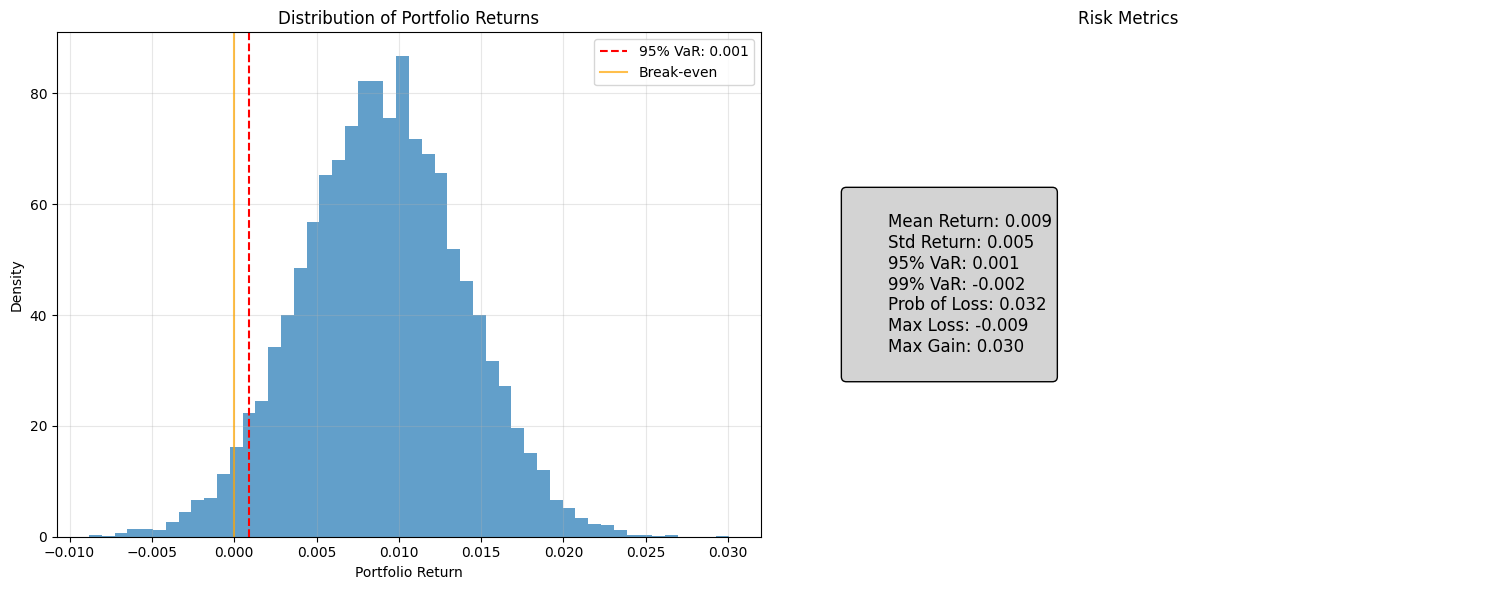

Risk Analysis Results:
  Expected Return: 0.0090
  Volatility: 0.0049
  95% VaR: 0.0009
  Probability of Loss: 0.0320
=== PORTFOLIO OPTIMIZATION PHASE ===
Using 78 stocks with confidence >= 0.3
Long positions: 50, Short positions: 28
Total portfolio allocation: 0.9000 (target: 0.9)
Portfolio Optimization Results:
  Number of positions: 78
  Total long weight: 0.6345
  Total short weight: 0.2525
  Net exposure: 0.3819
=== TRADING EXECUTION PHASE ===
Account value: $100,000.00
No positions to close
Liquidation Results:
  Successful closes: 0
  Failed closes: 0
Executing 66 orders...
Order submitted: BUY 3 shares of GOOG
Order submitted: BUY 1 shares of AAPL
Order submitted: BUY 46 shares of ADM
Order submitted: BUY 10 shares of ADBE
Order submitted: BUY 1 shares of AEP
Order submitted: BUY 2 shares of ALB
Order submitted: BUY 74 shares of ARE
Order submitted: BUY 23 shares of T
Order submitted: BUY 1 shares of AMP
Order submitted: BUY 5 shares of ALL
Order submitted: BUY 702 shares of AE

In [47]:
if __name__ == "__main__":
    try:
        # Run complete pipeline
        system = StockPredictionTradingSystem()
        results = system.run_complete_pipeline(dry_run=False)
        
        # Save final results
        results_file = os.path.join(config.RESULTS_SAVE_PATH, 
                                  f"complete_pipeline_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
        with open(results_file, 'w') as f:
            json.dump(results, f, indent=2, default=str)
        
        print(f"Complete results saved to: {results_file}")
        
    except KeyboardInterrupt:
        print("Execution interrupted by user")
    except Exception as e:
        print(f"Execution failed: {e}")
        raise
    
    print("Program completed")